# Detecting Gravitional Waves Using Topological algorithms

Authors:
* Christian Jaffé Alarcón Acosta - A00832881
* José Andrés Orantes Guillén - A01174130
* Juan José Montes Raygoza - A00834630
* Pedro Fernández Merino - A01733006
* Rubén Darío Castro Terrazas - A00833945



### Import libraries and dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from data.generate_datasets import make_gravitational_waves
from pathlib import Path
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.cm as cm
import gudhi as gd
from sklearn.decomposition import PCA
from nolitsa import dimension, delay
from gtda.plotting import plot_point_cloud
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
import matplotlib.patches as patches
import kmapper as km
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from persim import plot_diagrams
from ripser import ripser
import kmapper as km
from sklearn.cluster import KMeans
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding

sb.set(style="whitegrid")
plt.rcParams.update(plt.rcParamsDefault) #Permitir Latex

### Motivation


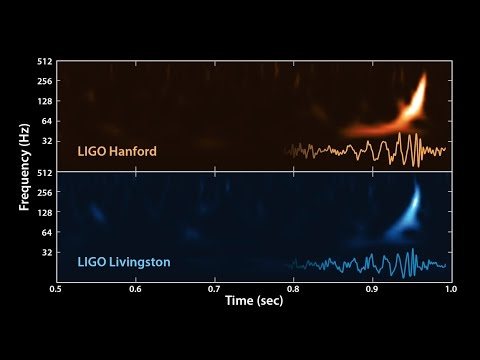

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

### Generate the data

The data was obtanined from the giotto-tda library: https://github.com/giotto-ai/giotto-tda/blob/master/examples/gravitational_waves_detection.ipynb

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series of the form

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

In [3]:

R = 0.65
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


Plot the data (gravitational waves)

In [4]:
# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

In [5]:
labels[0]

0.0

In [6]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(x=list(range(len(noisy_signals[0]))), y=noisy_signals[0], mode="lines", name="signal"),
    row=1,
    col=1,
)
fig.show()

In [7]:
ts_signal.shape

(8192,)

In [8]:

#initial_segment = ts_signal[:3000]  # Adjust the range according to your data
#threshold = max(abs(initial_segment)) * 1.1  # Slightly higher than the max of the initial part

# Find the index where the signal first exceeds the threshold
#indices = np.where(abs(ts_signal) > threshold)[0]

# Check if indices is empty
#if indices.size > 0:
    #cut_off_index = indices[0]
    #truncated_signal = ts_signal[:cut_off_index]
#else:
    #print("No points exceed the threshold")
    #truncated_signal = ts_signal  # No truncation if the threshold is not exceeded

#ts_signal =  truncated_signal


In [9]:
fig2 = make_subplots(rows=1, cols=1)

fig2.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=1,
)
fig2.show()

### Encaje de Takens

#### Parámetros óptimos de $\tau$ y $d$

* $\tau$: tiempo de retardo
* $d$: dimensión 

In [10]:
ts_noise.shape #dimension de los datos con ruido
max_parameters =  int(round(np.sqrt(ts_noise.shape[0]),0))
max_parameters

93

In [11]:
def find_optimal_delay(x, maxtau):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)
    return int(np.where(diffmi > 0)[0][0]) #returns the first element in which the difference is greater than 0. It means that gives you the local optimal
    #print(np.where(diffmi > 0))

In [12]:
tau_ts_noise  = find_optimal_delay(ts_noise,maxtau=max_parameters) #ejemplo
tau_ts_signal  = find_optimal_delay(ts_signal,maxtau=max_parameters) #ejemplo
print(f'El óptimo local para los datos con ruido es : {tau_ts_noise}')
print(f'El óptimo local para los datos sin ruido es : {tau_ts_signal}')

El óptimo local para los datos con ruido es : 3
El óptimo local para los datos sin ruido es : 20


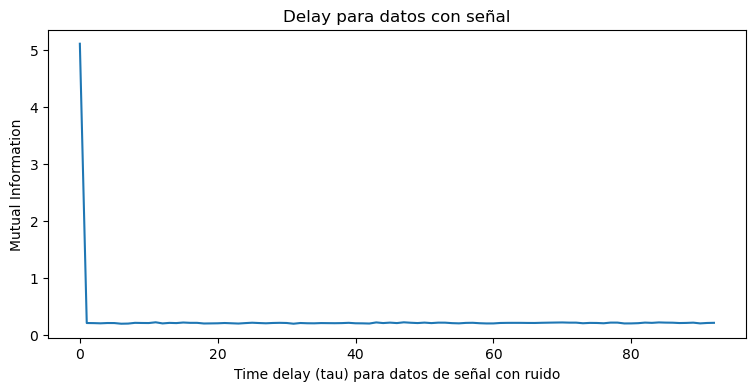

In [13]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau) para datos de señal con ruido')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(ts_noise, maxtau=max_parameters))
plt.title("Delay para datos con señal")
plt.show()

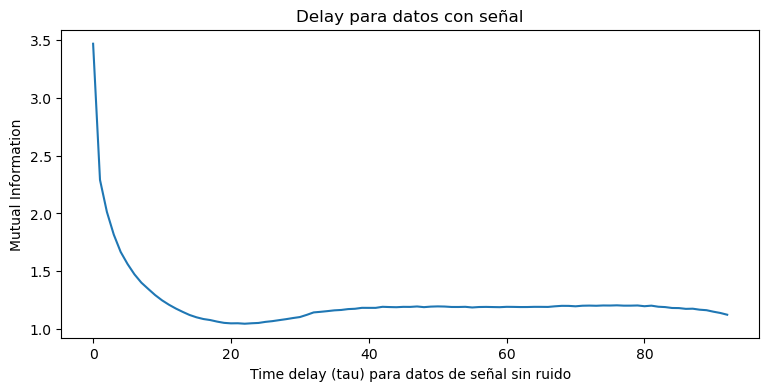

In [14]:
#sin ruido
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau) para datos de señal sin ruido')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(ts_signal, maxtau=max_parameters))
plt.title("Delay para datos con señal")
plt.show()

In [15]:
def find_optimal_dimension(y,tau):
    dim =  np.arange(1,10)
    f1, f2, f3 = dimension.fnn(y, tau=tau, dim=dim)
    diff_f1 = np.diff(f1)
    #print(f1)
    optimal_d = int(np.where(diff_f1 == 0)[0][0]) 

    #changeOf_diff_f1 = np.diff(diff_f1) 
    #optimal_dimension = np.argmax(changeOf_diff_f1) + 2
    return optimal_d


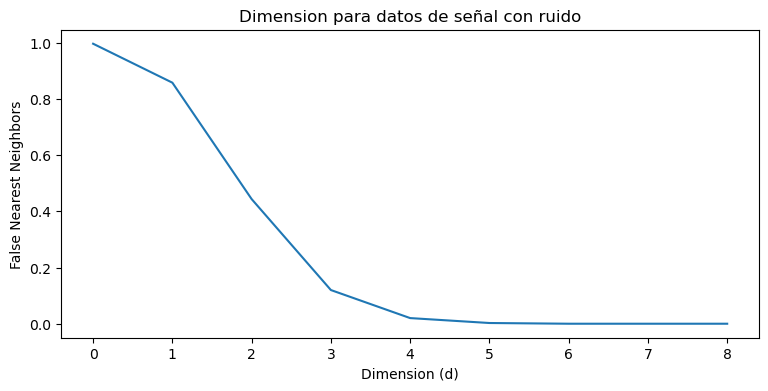

d:  6


In [16]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ts_noise, tau=tau_ts_noise, dim=dim) #Ejemplo

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors')
plt.title("Dimension para datos de señal con ruido")
plt.plot(f1)
plt.show()
print("d: ",find_optimal_dimension(ts_noise,tau_ts_noise))

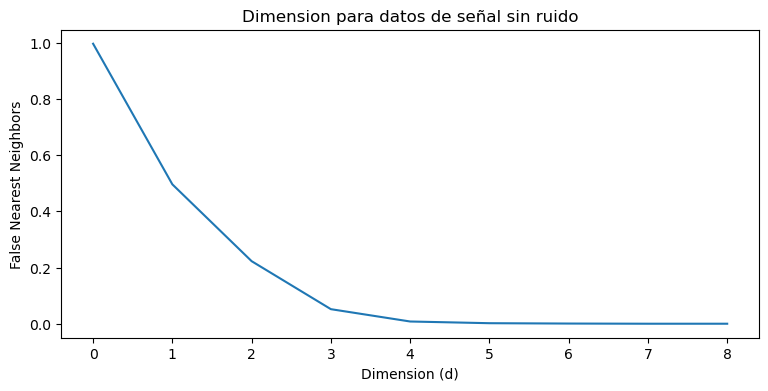

d:  6


In [17]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(ts_signal, tau=tau_ts_signal, dim=dim) #Ejemplo

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors')
plt.title("Dimension para datos de señal sin ruido")
plt.plot(f1)
plt.show()
print("d: ",find_optimal_dimension(ts_noise,tau_ts_noise))

Vamos a elegir la dimension 3.

### Aplicar el Encaje

In [18]:
#Estandarizar datos
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
#scaler.fit(ts_noise.reshape(-1,1))
ts_noise_scaled = scaler.fit_transform(ts_noise.reshape(-1,1))
ts_noise_scaled.shape

(8692, 1)

In [19]:
ts_signal_scaled = scaler.fit_transform(ts_signal.reshape(-1,1))
ts_signal_scaled.shape

(8192, 1)

In [32]:
labels

array([0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [33]:
our_stride = 15
dim =  3

#con ruido
embedder_noise = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=tau_ts_noise, dimension=2, stride=our_stride
)

y_embedded_noise = embedder_noise.fit_transform(noisy_signals[0])

In [43]:
#sin ruido
embedder_signal = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay= tau_ts_signal, dimension=2, stride=our_stride
)

y_embedded_signal = embedder_signal.fit_transform(noisy_signals[2])

In [35]:
y_embedded_noise.shape

(580, 2)

In [36]:
y_embedded_signal.shape

(545, 2)

In [37]:
plot_point_cloud(y_embedded_noise)

In [38]:
ts_signal.shape

(8192,)

In [44]:
plot_point_cloud(y_embedded_signal)

### Analisis de persistencia

In [40]:
result_noise = ripser(y_embedded_noise,maxdim=2)
diagrams_noise = result_noise['dgms']
diagrams_noise

[array([[0.00000000e+00, 5.26255093e-22],
        [0.00000000e+00, 5.31093776e-22],
        [0.00000000e+00, 6.39656284e-22],
        ...,
        [0.00000000e+00, 1.06197247e-19],
        [0.00000000e+00, 1.54810600e-19],
        [0.00000000e+00,            inf]]),
 array([[1.10710112e-19, 1.12545173e-19],
        [1.08901274e-19, 1.20276339e-19],
        [1.06197195e-19, 1.14046454e-19],
        [1.05141616e-19, 1.09588545e-19],
        [1.03487746e-19, 1.11601967e-19],
        [1.03471325e-19, 1.18602578e-19],
        [9.06920113e-20, 9.62457988e-20],
        [8.53657695e-20, 8.88518123e-20],
        [7.80136137e-20, 9.30700134e-20],
        [7.51144167e-20, 8.32842987e-20],
        [7.16743987e-20, 8.56951231e-20],
        [7.07660123e-20, 8.38071544e-20],
        [6.69394489e-20, 7.69232733e-20],
        [6.60522460e-20, 7.33046554e-20],
        [6.50198794e-20, 7.14673386e-20],
        [6.13875354e-20, 6.15864723e-20],
        [5.86076463e-20, 7.11983757e-20],
        [5.76882545

In [41]:
dmg1_noise=diagrams_noise[1] #datos de B_1
huecos_noise = pd.DataFrame(dmg1_noise, columns=['Birth', 'Death'])
huecos_noise['Life'] = huecos_noise['Death'] - huecos_noise['Birth']
huecos_noise = huecos_noise.sort_values(by='Life', ascending=False)
index =pd.Series(range(len(huecos_noise.index))) #index
huecos_noise['huecos_noise'] = index
huecos_noise.head(10)

,Birth,Death,Life,huecos_noise
98,2.673801e-20,6.912330e-20,4.238530e-20,98
68,3.228679e-20,6.019267e-20,2.790588e-20,68
27,4.881319e-20,7.629219e-20,2.747899e-20,27
41,4.187379e-20,6.670305e-20,2.482926e-20,41
26,5.050056e-20,7.515127e-20,2.465071e-20,26
97,2.727183e-20,4.893333e-20,2.166150e-20,97
121,2.234996e-20,4.359911e-20,2.124914e-20,121
138,2.041648e-20,4.158595e-20,2.116948e-20,138
23,5.181048e-20,7.268001e-20,2.086953e-20,23
40,4.235732e-20,6.279467e-20,2.043735e-20,40


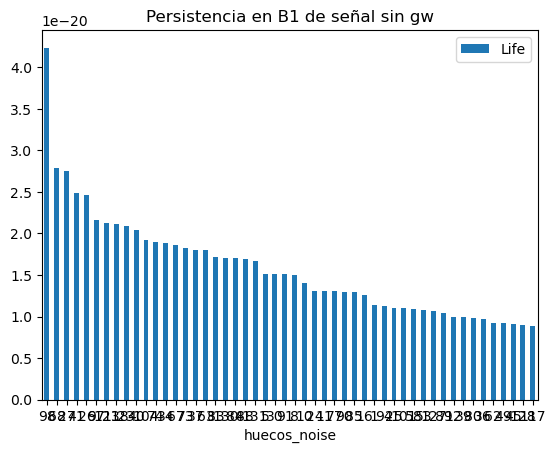

In [56]:
huecos_noise_top10 = huecos_noise.iloc[:50,:]
huecos_noise_top10.plot.bar(x='huecos_noise', y='Life', rot=0) #plot la persistencia de los huecos de la señal con ruido
plt.title("Persistencia en B1 de señal sin gw")
plt.show()

In [51]:
result_signal = ripser(y_embedded_signal,maxdim=2)
diagrams_signal = result_signal['dgms']
diagrams_signal

[array([[0.00000000e+00, 5.94983078e-22],
        [0.00000000e+00, 6.33774890e-22],
        [0.00000000e+00, 8.57112696e-22],
        ...,
        [0.00000000e+00, 1.36936648e-19],
        [0.00000000e+00, 1.45507804e-19],
        [0.00000000e+00,            inf]]),
 array([[1.33944568e-19, 1.48485783e-19],
        [8.91844875e-20, 9.67423851e-20],
        [8.90188317e-20, 9.45142836e-20],
        [8.78338050e-20, 1.01019510e-19],
        [8.66303735e-20, 1.00882159e-19],
        [8.31038118e-20, 9.69441913e-20],
        [7.81920908e-20, 1.10856885e-19],
        [7.53925885e-20, 1.13451349e-19],
        [6.69915225e-20, 7.02083891e-20],
        [6.62092100e-20, 9.34635510e-20],
        [6.61724198e-20, 6.62051128e-20],
        [6.51208988e-20, 7.10409206e-20],
        [6.25389514e-20, 9.46299403e-20],
        [6.08216017e-20, 6.72465332e-20],
        [5.94926133e-20, 6.04421391e-20],
        [5.73478503e-20, 5.96503075e-20],
        [5.54893176e-20, 7.52227580e-20],
        [5.46096175

In [52]:
y_embedded_signal.shape

(579, 2)

In [53]:
dmg1_signal = diagrams_signal[1] #datos de B_1
huecos_signal = pd.DataFrame(dmg1_signal, columns=['Birth', 'Death'])
huecos_signal['Life'] = huecos_signal['Death'] - huecos_signal['Birth']
huecos_signal = huecos_signal.sort_values(by='Life', ascending=False)
index =pd.Series(range(len(huecos_signal.index))) #index
huecos_signal['huecos_signal'] = index
huecos_signal.head(10)

,Birth,Death,Life,huecos_signal
7,7.539259e-20,1.134513e-19,3.805876e-20,7
73,3.121619e-20,6.623592e-20,3.501973e-20,73
6,7.819209e-20,1.108569e-19,3.266479e-20,6
12,6.253895e-20,9.462994e-20,3.209099e-20,12
35,4.205610e-20,7.267220e-20,3.061611e-20,35
27,4.655346e-20,7.685791e-20,3.030445e-20,27
110,2.580256e-20,5.426919e-20,2.846663e-20,110
9,6.620921e-20,9.346355e-20,2.725434e-20,9
52,3.600808e-20,6.285239e-20,2.684431e-20,52
32,4.381034e-20,6.988490e-20,2.607456e-20,32


In [48]:
lifetime_signal = sorted([lifetime[1] - lifetime[0] for lifetime in dmg1_signal],reverse=True)   
lifetime_signal

[3.80587609293238e-20,
 3.5019731670546653e-20,
 3.266479370304793e-20,
 3.2090988851877554e-20,
 3.061610966382417e-20,
 3.030444998099921e-20,
 2.8466630758903974e-20,
 2.7254341025657826e-20,
 2.684431470459868e-20,
 2.6074561752307e-20,
 2.528817471488476e-20,
 2.518403396823404e-20,
 2.2424132929753793e-20,
 2.111445721966373e-20,
 1.9995950703952916e-20,
 1.9733440412915238e-20,
 1.9704153049352032e-20,
 1.9268015609034913e-20,
 1.922328646364596e-20,
 1.9218491401032568e-20,
 1.6464248148695212e-20,
 1.6301164321051554e-20,
 1.6288048984698614e-20,
 1.59037266549397e-20,
 1.521940595028826e-20,
 1.5173352023449518e-20,
 1.503056320138182e-20,
 1.4541214783222812e-20,
 1.446554391304555e-20,
 1.4251785579360214e-20,
 1.3967206368073563e-20,
 1.3840379546888723e-20,
 1.3276436239583626e-20,
 1.3185704866144216e-20,
 1.2897325793918648e-20,
 1.2847788661219233e-20,
 1.2470778478828316e-20,
 1.2277166516702623e-20,
 1.1752627379593166e-20,
 1.1604293862481948e-20,
 1.145586017896842

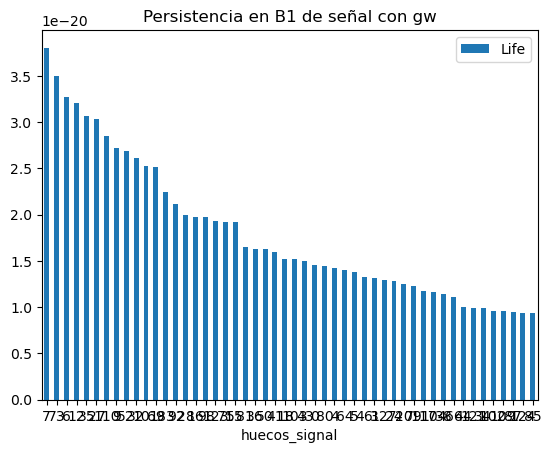

In [58]:
huecos_signal_top20 = huecos_signal.iloc[:50,:]
huecos_signal_top20.plot.bar(x='huecos_signal', y='Life', rot=0) #plot la persistencia de los huecos de la señal con ruido
plt.title("Persistencia en B1 de señal con gw")
plt.show()

In [ ]:
#skeletonCirc_noise = gd.RipsComplex(points=y_embedded_noise, max_edge_length = 2)
#Rips_simplex_tree_Circ_noise = skeletonCirc_noise.create_simplex_tree(max_dimension = 2)
#Barcodes_Rips_Circ_noise = Rips_simplex_tree_Circ_noise.persistence()
#gd.plot_persistence_diagram(Barcodes_Rips_Circ_noise);
#plt.title(f'Persistence Diagram for signal with noise')
#plt.show()    

In [34]:
#diag_inf = Rips_simplex_tree_Circ_noise.persistence(min_persistence=0)
#gd.plot_persistence_barcode(diag_inf);
#plt.title(f'Persistence of Barcodes for noise')
#plt.show()

In [35]:
#skeletonCirc_signal = gd.RipsComplex(points=y_embedded_signal, max_edge_length = 2)
#Rips_simplex_tree_Circ_signal = skeletonCirc_signal.create_simplex_tree(max_dimension = 2)
#Barcodes_Rips_Circ_signal = Rips_simplex_tree_Circ_signal.persistence()
#gd.plot_persistence_diagram(Barcodes_Rips_Circ_signal);
#plt.title(f'Persistence Diagram for signal with no noise')
#plt.show()    

In [36]:
#diag_inf = Rips_simplex_tree_Circ_signal.persistence(min_persistence=0)
#gd.plot_persistence_barcode(diag_inf);
#plt.title(f'Persistence of Barcodes for signal')
#plt.show()

In [37]:
#barcodes
#simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
#Notemos con esta paquetería se queda con lo más significativo si cambiamos la persistencia
#diag0 = simplex_tree.persistence(min_persistence=0)
#gudhi.plot_persistence_barcode(diag0)
#plt.show()

### Generar vectores para 10 señales 

In [38]:
import random

def generar_señales_(n_of_signals):

    scaler =  StandardScaler()
    n_signals = 100
    signals = []
    for i in range(n_of_signals):
        R = random.uniform(0.075,0.65)
        DATA = Path("./data")
        noisy_signals, gw_signals, labels = make_gravitational_waves(
            path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
        )

        # get the index corresponding to the first pure noise time series
        background_idx = np.argmin(labels)
        # get the index corresponding to the first noise + gravitational wave time series
        signal_idx = np.argmax(labels)

        ts_noise = noisy_signals[background_idx]
        ts_background = noisy_signals[signal_idx]
        ts_signal = gw_signals[signal_idx]


        ts_noise_scaled = scaler.fit_transform(ts_noise.reshape(-1,1))
        ts_signal_scaled = scaler.fit_transform(ts_signal.reshape(-1,1))
        
        #con ruido
        embedder_noise = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay= 90, dimension=90, stride=15
        )

        embedder_signal = SingleTakensEmbedding(
            parameters_type="search", n_jobs=6, time_delay= 90, dimension=90, stride=15
        )

        y_embedded_noise = embedder_noise.fit_transform(ts_noise_scaled)
        y_embedded_signal = embedder_signal.fit_transform(ts_signal_scaled)

        #analisis de persistencia con ruido
        result_noise = ripser(y_embedded_noise,maxdim=2)
        diagrams_noise = result_noise['dgms']
        dmg1_noise = diagrams_noise[1] #datos de B_1

        lifetime_b1_noise = sorted([lifetime[1] - lifetime[0] for lifetime in dmg1_noise],reverse=True)
        #lifetime_b1_noise.append("noise")

        #analisis de persistencia sin ruido
        result_signal = ripser(y_embedded_signal,maxdim=2)
        diagrams_signal = result_signal['dgms']
        dmg1_signal = diagrams_signal[1] #datos de B_1

        lifetime_b1_signal = sorted([lifetime[1] - lifetime[0] for lifetime in dmg1_signal],reverse=True)
        #lifetime_b1_signal.append("signal")

        signals.append(lifetime_b1_noise)#Agregar el del ruido  
        signals.append(lifetime_b1_signal)  #Agregar la señal

    

    #encontrar la señal que tiene menos datos
    min_data = len(signals[0]) #primer punto
    for signal in signals:
        if len(signal) < min_data:
            min_data = len(signal)
    
    for i in range(len(signals)):
        signals[i] = signals[i][:min_data]
    
    counter = 1
    #identifar la señal como la ruidosa o limpia, esto se hace en base al orden en la que se hizo el append al final del ciclo for de arriba
    for i in range(1,len(signals)+ 1):
        if i % 2 == 1:
            signals[i-1].append("noise")
        else:
           signals[i-1].append("signal") 



    return signals
    

In [118]:
import random
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding


def obtener_lifetime_b1_señales(signals,labels):

    embedding_dimension = 200
    embedding_time_delay = 10
    stride = 15

    embedder = TakensEmbedding(time_delay=embedding_time_delay,dimension=embedding_dimension,stride=stride)

    batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

    persistence = VietorisRipsPersistence(homology_dimensions=[1], n_jobs=-1)

    scaling = Scaler()


    steps = [
         ("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling)
     ]
    
    
    topological_transfomer2 = Pipeline(steps)



    features = topological_transfomer2.fit_transform(signals)

    persistence_signals = []
    for i in range(features.shape[0]):
        lifetime_data = []
        for j in range(features.shape[1]):
            life_b1 = features[i][j][0]
            death_b1 = features[i][j][1]
            lifetime_b1 = death_b1 - life_b1
            lifetime_data.append(lifetime_b1) 
        
        lifetime_data = sorted(lifetime_data,reverse=True)
        lifetime_data.append(labels[i])
        persistence_signals.append(np.array(lifetime_data))

    return np.array(persistence_signals)
    

In [119]:
noisy_signals_b1 = obtener_lifetime_b1_señales(noisy_signals,labels)

c:\Users\Ruben\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py:121: FutureWarning:

if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use available_if instead.



In [122]:
datos_b1 = pd.DataFrame(noisy_signals_b1)
datos_b1

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
0,0.699886,0.673249,0.633735,0.607163,0.581062,0.440210,0.427230,0.384592,0.379101,0.370899,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.677619,0.671661,0.660272,0.617593,0.580183,0.510488,0.464481,0.437890,0.415127,0.396168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.389672,1.299218,1.068889,0.966674,0.856888,0.816201,0.715938,0.705629,0.676231,0.620521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.602958,0.506011,0.476734,0.424379,0.412444,0.410826,0.408294,0.393165,0.392688,0.384632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.578690,0.522158,0.428200,0.407731,0.399460,0.361513,0.333549,0.326281,0.325906,0.314948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.441519,0.402134,0.395426,0.385906,0.379282,0.369363,0.350817,0.340141,0.329074,0.314703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
96,0.571815,0.485590,0.469890,0.456732,0.422064,0.388167,0.381274,0.353021,0.333376,0.319855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,0.550898,0.519087,0.462780,0.435269,0.432664,0.391748,0.376138,0.371899,0.350223,0.347463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.533210,0.488191,0.476843,0.441431,0.437161,0.403430,0.375279,0.360900,0.349804,0.348407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [123]:
new_columns =  list(datos_b1.columns)
new_columns[-1] = "tipo_señal"
datos_b1.columns =new_columns
datos_b1

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,tipo_señal
0,0.699886,0.673249,0.633735,0.607163,0.581062,0.440210,0.427230,0.384592,0.379101,0.370899,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.677619,0.671661,0.660272,0.617593,0.580183,0.510488,0.464481,0.437890,0.415127,0.396168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.389672,1.299218,1.068889,0.966674,0.856888,0.816201,0.715938,0.705629,0.676231,0.620521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.602958,0.506011,0.476734,0.424379,0.412444,0.410826,0.408294,0.393165,0.392688,0.384632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.578690,0.522158,0.428200,0.407731,0.399460,0.361513,0.333549,0.326281,0.325906,0.314948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.441519,0.402134,0.395426,0.385906,0.379282,0.369363,0.350817,0.340141,0.329074,0.314703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
96,0.571815,0.485590,0.469890,0.456732,0.422064,0.388167,0.381274,0.353021,0.333376,0.319855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,0.550898,0.519087,0.462780,0.435269,0.432664,0.391748,0.376138,0.371899,0.350223,0.347463,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.533210,0.488191,0.476843,0.441431,0.437161,0.403430,0.375279,0.360900,0.349804,0.348407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Guardar los datos

In [124]:
datos_b1.to_csv("señales_b1_100.csv",index=False)